In [2]:
from triqs.gf import *
from triqs.operators import *
from triqs.gf import Fourier
from h5 import *
import triqs.utility.mpi as mpi

from triqs.operators import *
from triqs_cthyb import Solver

from triqs.plot.mpl_interface import oplot,plt
from triqs.gf import MeshImTime
from triqs.gf import GfImFreq, GfImTime, make_gf_from_fourier

from triqs.gf import  MeshImTime, MeshReFreq, Gf
from triqs.plot.mpl_interface import oplot, plt

Starting serial run at: 2024-09-04 18:24:55.538780


In [3]:
from multiprocessing import Pool
from itertools import repeat
from functools import partial

%matplotlib inline
import csv
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# from pymatgen.electronic_structure.plotter import BSDOSPlotter, BSPlotter, DosPlotter
# from pymatgen.io.vasp.outputs import BSVasprun, Vasprun

import pickle 
from  tqdm import tqdm

In [4]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)


In [5]:
import sys
sys.path.append("./src")
%load_ext autoreload
%autoreload 2
# import DataBase
# import ml_model
# import Sample 
from band_generation import Band_generator
from util import * 


In [6]:
bg = Band_generator()
bg.load_checkpoint('./models/AUTOmodel_v3')
        

model loaded from ./models/AUTOmodel_v3


# One sample

In [11]:
class sample():
    def __init__(self, 
                 beta=5.0, 
                 U=2.0, 
                 num_kpoints=21, 
                 n_iw=500,
                 n_tau=3001, 
                 n_w=500,
                 e_window=4.0,
                 BS=None,
                 G0_iw=None,
                 G0w=None,
                 G0tau=None,
                 G0_legendre=None,
                 Gw=None,
                 Giw=None,
                 G_legendre=None,
                 Gtau=None,
                 Sigma_iw=None
                 ):

        self.beta = beta
        self.num_kpoints = num_kpoints
        self.n_iw = n_iw
        self.n_tau = n_tau
        self.n_w = n_w
        self.U = U
        self.e_window = e_window

        self.kpoints= np.linspace(-np.pi, np.pi, 10)
        # kx = np.linspace(-0.5, 0.5, 10)
        # ky = np.linspace(-0.5, 0.5, 10)
        # kx, ky = np.meshgrid(kx, ky)
        # self.kpoints = [kx, ky]

        self.niwmesh = np.linspace(-n_iw-1, n_iw, 2*n_iw)
        self.iwmesh = np.pi*(2*self.niwmesh+1)/self.beta
        self.taumesh = np.linspace(0, self.beta, self.n_tau)
        self.wmesh = np.linspace(-e_window, e_window, self.n_w)
        

        if G0_iw is not None:
            self.BS = BS
            self.G0_iw = G0_iw
            self.G0w = G0w
            self.G0tau = G0tau
            self.G0_legendre = G0_legendre
            self.Gw = Gw
            self.Giw = Giw
            self.G_legendre = G_legendre
            self.Gtau = Gtau
            self.Sigma_iw = Sigma_iw
        else:
            self.Gw = 0
            self.Giw = 0
            self.G_legendre = 0
            self.Gtau = 0
            self.Sigma_iw = 0
            self.get_BS()
            self.get_Green()


        
    @classmethod
    def fromdict(cls, datadict):
        "Initialize sample from a dict's items"
        return cls(**datadict)

    def save2dict(self):
        dict2save = {}
        dict2save['beta'] = self.beta 
        dict2save['U'] = self.U
        dict2save['num_kpoints'] = self.num_kpoints 
        dict2save['BS'] = self.BS 
        dict2save['n_iw'] = self.n_iw
        dict2save['n_tau'] = self.n_tau 
        dict2save['n_w'] = self.n_w
        dict2save['e_window'] = self.e_window
        dict2save['G0_iw'] = self.G0_iw
        dict2save['G0w'] = self.G0w
        dict2save['G0tau'] = self.G0tau
        dict2save['G0_legendre'] = self.G0_legendre
        dict2save['Gw'] = self.Gw
        dict2save['Giw'] = self.Giw
        dict2save['G_legendre'] = self.G_legendre
        dict2save['Gtau'] = self.Gtau
        dict2save['Sigma_iw'] = self.Sigma_iw
        return dict2save


    def get_BS(self):
        # t1 = np.random.rand()*1.5
        # t2 = np.random.rand()
        # t3 = np.random.rand()
        # kpts = self.kpoints
        # BS = 2 * t1 * np.cos(kpts) + 2 * t2 * np.cos(2 * kpts) + 2 * t3 * np.cos(3 * kpts)
        # self.BS = -BS - np.mean(-BS)
        # print(BS)
        bg = Band_generator()
        bg.load_checkpoint('./models/AUTOmodel_v3')
        self.BS = bg.getBS().flatten()


    def plotBS(self):
        # fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

        # ax1.plot(self.kpoints, self.BS, label="BS")

        # ax1.set_title("tmp BS")
        # ax1.set_xlabel("k")
        # ax1.set_ylabel("e")
        # # add_text(ax1, "p=0.1\ngamma=0.002", ts, Ps_a, 0.01, 0.01)
        # # ax1.legend()
        # for ax in [ax1]:
        #     ax.grid(alpha=0.5)
        # plt.tight_layout()
        # plt.show()

        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='3d')


        kx = np.linspace(-0.5, 0.5, 10)
        ky = np.linspace(-0.5, 0.5, 10)
        kx, ky = np.meshgrid(kx, ky)

        ax.plot_surface(kx, ky, np.reshape(self.BS, (10, 10)), cmap='viridis')

        # Add labels
        ax.set_xlabel('kx')
        ax.set_ylabel('ky')
        ax.set_zlabel('Energy')
        # ax.set_zlim((-4, 2))
        # Show the plot
        plt.show()


    def get_Green(self, saveQ=False):
        ''' 
        important

        self.G0_iw
        self.G0w
        self.G0tau
        self.G0_legendre
        '''
        # print(self.num_kpoints)
        # iw_mesh = MeshImFreq(beta=self.beta, S='Fermion', n_iw=self.n_iw)
        # self.Gks = [Gf(mesh=iw_mesh, target_shape=[1, 1]) for kpt in range(len(self.BS.flatten()))]
        # for kpt_ind, e_kpt in enumerate(self.BS.flatten()):
        #     self.Gks[kpt_ind] << inverse(iOmega_n - e_kpt - 0.001j)
        # self.Gks = np.array(self.Gks)

        # dSarea = 1.0/(self.num_kpoints)
        # # print(self.Gks.shape)

        mesh = MeshImFreq(beta=self.beta, S='Fermion', n_iw=self.n_iw)
        Gks = [Gf(mesh=mesh, target_shape=[1, 1]) for kpt in range(len(self.BS))]
        for kpt_ind, e in enumerate(self.BS ):
            Gks[kpt_ind] << inverse(iOmega_n - e)
        Gks = np.array(Gks)
        self.G0_iw = np.sum( Gks, axis=0 ) /float(len(self.BS))
        # print(self.G0_iw)

        # ### G0(w)
        # w_mesh = MeshReFreq(window=(-4,4), n_w=self.n_w)
        # self.G0w = Gf(mesh=w_mesh, target_shape=[1,1])
        # #TODO n_points is a parameter that should be chosen that way to fullfill intergal dos is close to 1 and is nonnegative 
        # arr = np.imag(self.G0_iw.data.flatten())
        # n_points = findExtrema(arr)*3
        # n_points = 10
        # self.G0w.set_from_pade(self.G0_iw, n_points = n_points, freq_offset = 0.05)

        ### G0(tau)
        tau_mesh = MeshImTime(beta=self.beta, statistic='Fermion', n_tau=self.n_tau)
        #Mesh-points are evenly distributed in the interval [0,beta] including points at both edges.
        self.G0tau = Gf(mesh=tau_mesh, target_shape=[1,1])
        self.G0tau << Fourier(self.G0_iw)

        ### G0(legendre)
        self.G0_legendre = GfLegendre(indices = [1], beta = self.beta, n_points = 40)
        self.G0_legendre << MatsubaraToLegendre(self.G0_iw)

        # if saveQ:
        #     with HDFArchive("features"+str(1) +".h5") as ar:
        #         ar["G0_tau-%s"%1] = self.G0tau
        #         ar["G0_iw-%s"%1] = self.G0_iw
        #         ar["G0_w-%s"%1] = self.G0w
        #         ar["G0_l-%s"%1] = self.G0_legendre
            

    def solve_impurity(self, n_cycles=5000,
                             length_cycle=1000,
                             n_warmup_cycles=10000, saveQ=False):
        ''' 
        important
        
        self.Gw
        self.Giw
        self.G_legendre
        self.Gtau
        self.Sigma_iw
        
        '''
        S = Solver(beta = self.beta, 
                   n_iw=self.n_iw, 
                   n_tau=self.n_tau, 
                   gf_struct = [ ('up',1), ('down',1) ])
        
        for name, g0 in S.G0_iw:
            g0 <<  self.G0_iw

        S.solve(h_int = self.U * n('up',0) * n('down',0),    # Local Hamiltonian
                n_cycles = n_cycles,                        # Number of QMC cycles
                length_cycle = length_cycle,                     # Length of a cycle
                n_warmup_cycles = n_warmup_cycles,                 # How many warmup cycles
                measure_G_l=True)
        
        
        
        g = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
        
        #TODO energy window should be chosen wisely 
        w_mesh = MeshReFreq(window=(-4,4), n_w=self.n_w)
        self.Gw = Gf(mesh=w_mesh, target_shape=[1,1])
        
        #TODO n_points is a parameter that should be chosen that way to fullfill intergal dos is close to 1 and is nonnegative 
        self.Gw
        self.G_legendre = 0.5 * (S.G_l['up'] + S.G_l['down'])
        self.Gtau = 0.5 * (S.G_tau['up'] + S.G_tau['down'])
        
        if saveQ:
            with HDFArchive("targets"+str(1) +".h5") as ar:
                ar["G_tau-%s"%1] = 0.5 * (S.G_tau['up'] + S.G_tau['down'])
                ar["G_iw-%s"%1] = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
                ar["G_l-%s"%1] =  0.5 * (S.G_l['up'] + S.G_l['down'])
                ar["Sigma_iw-%s"%1] = 0.5 * (S.Sigma_iw['up'] + S.Sigma_iw['down'])

    def plot_DOS(self, sigma=0.2):
        energy_min = -5  # Minimum energy value
        energy_max = 5   # Maximum energy value
        n_points = 100   # Number of points in the energy grid
        energy_grid = np.linspace(energy_min, energy_max, n_points)

        # sigma = 0.5

        # Step 4: Initialize the DOS array
        dos = np.zeros_like(energy_grid)

        # Step 5: Sum the Gaussians centered at each discrete energy level
        for energy in self.BS.flatten():
            dos += gaussian(energy_grid, energy, sigma)
        dos_integral = np.trapz(dos, energy_grid)  # Compute the integral of the DOS
        dos /= dos_integral  # Normalize the DOS
        # Step 6: Plot the DOS
        dos_integral2 = np.trapz(-np.imag(self.G0w.data.flatten()), self.wmesh)  # Compute the integral of the DOS
        print(dos_integral2)
        plt.plot(self.wmesh, -np.imag(self.G0w.data.flatten())/dos_integral2, label='from Green')
        plt.plot(energy_grid, dos, label=f'Gaussian Broadened DOS (sigma={sigma})')
        plt.xlabel('Energy')
        plt.ylabel('Density of States (DOS)')
        plt.title('Gaussian Broadened Density of States')
        plt.legend()
        plt.show()

    def plot_G(self, which='iw'):
        
            fig, dd = plt.subplots(figsize=(6,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.wmesh, np.real(self.Gw.data.flatten()), label='re')
            dd.plot(self.wmesh, np.imag(self.Gw.data.flatten()), label='im')
            # width = 10
            # fig.set_figwidth(width)     #  ширина и
            # fig.set_figheight(width/1.6)    #  высота "Figure"
            fig.set_label('Gw')
            plt.legend()
            # plt.xlim(-10, 10)

            plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

            # plt.xlabel("X Label", fontsize=10)
            # plt.ylabel("Y Label", fontsize=10)
            # plt.colorbar()
            # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

            plt.show()
        


    def plot_G0(self, which='iw'):
        if which == 'iw':
            fig, dd = plt.subplots(figsize=(6,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.niwmesh, np.real(self.G0_iw.data.flatten()), label='re')
            dd.plot(self.niwmesh, np.imag(self.G0_iw.data.flatten()), label='im')
            # width = 10
            # fig.set_figwidth(width)     #  ширина и
            # fig.set_figheight(width/1.6)    #  высота "Figure"
            fig.set_label('G0_iw')
            plt.legend()
            # plt.xlim(-10, 10)

            plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

            # plt.xlabel("X Label", fontsize=10)
            # plt.ylabel("Y Label", fontsize=10)
            # plt.colorbar()
            # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

            plt.show()

        elif which == 'w':
            fig, dd = plt.subplots(figsize=(6,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.wmesh, np.real(self.G0w.data.flatten()), label='re')
            dd.plot(self.wmesh, np.imag(self.G0w.data.flatten()), label='im')
            # width = 10
            # fig.set_figwidth(width)     #  ширина и
            # fig.set_figheight(width/1.6)    #  высота "Figure"
            fig.set_label('G0w')
            plt.legend()
            # plt.xlim(-10, 10)

            plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

            # plt.xlabel("X Label", fontsize=10)
            # plt.ylabel("Y Label", fontsize=10)
            # plt.colorbar()
            # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

            plt.show()
        elif which == 'tau':
            fig, dd = plt.subplots(figsize=(6,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.taumesh, np.real(self.G0tau.data.flatten()), label='re')
            dd.plot(self.taumesh, np.imag(self.G0tau.data.flatten()), label='im')
            # width = 10
            # fig.set_figwidth(width)     #  ширина и
            # fig.set_figheight(width/1.6)    #  высота "Figure"
            fig.set_label('G0tau')
            plt.legend()
            # plt.xlim(-10, 10)

            plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

            # plt.xlabel("X Label", fontsize=10)
            # plt.ylabel("Y Label", fontsize=10)
            # plt.colorbar()
            # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

            plt.show()

        elif which == 'legendre':
            fig, dd = plt.subplots(figsize=(6,3))
            # print(np.real(self.G0_iw))
            dd.scatter(np.arange(0, 40, 1), np.real(self.G0_legendre.data.flatten()), label='re')
            dd.scatter(np.arange(0, 40, 1), np.imag(self.G0_legendre.data.flatten()), label='im')
            # width = 10
            # fig.set_figwidth(width)     #  ширина и
            # fig.set_figheight(width/1.6)    #  высота "Figure"
            fig.set_label('G0leg')
            plt.legend()
            # plt.xlim(-10, 10)

            plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

            # plt.xlabel("X Label", fontsize=10)
            # plt.ylabel("Y Label", fontsize=10)
            # plt.colorbar()
            # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

            plt.show()



In [12]:
sample1 = sample(beta=20.0)


model loaded from ./models/AUTOmodel_v3


In [15]:
# sample1.plotBS()
# sample1.plot_DOS(0.3)
# sample1.plot_G0('iw')
# sample1.plot_G0('w')
# sample1.plot_G0('tau')
# sample1.plot_G0('legendre')

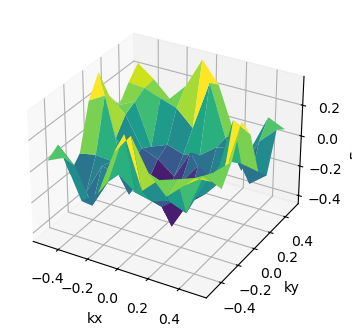

In [16]:
sample1.plotBS()

In [13]:
sample1.solve_impurity()


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-0.00737423*c_dag('down',0)*c('down',0) + -0.00737423*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
18:25:43   0% ETA 00:00:11 cycle 87 of 10000
18:25:45  19% ETA 00:00:08 cycle 1924 of 10000
18:25:48  42% ETA 00:00:06 cycle 4267 of 10000
18:25:51  71% ETA 00:00:03 cycle 7195 of 10000
18:25:54 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
18:25:54   1% ETA 00:00:05 cycle 90 of 5000
18:25:56  38% ETA 00:00:03 cycle 1943 of 5000
18:25:59  84% ETA 00:00:00 cycle 4233 of 5000
18:26:00 100% ETA 00:00:00 cycle 4999 of 5000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00909433
Averag

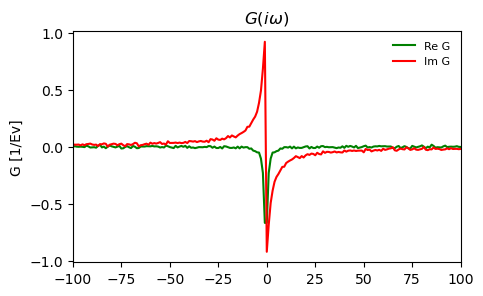

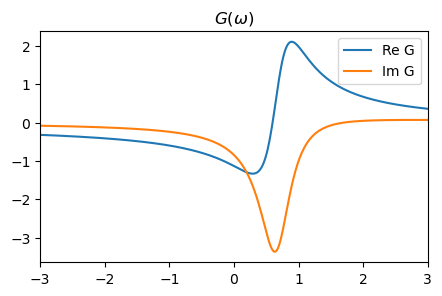

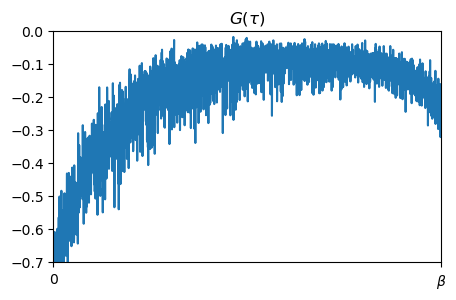

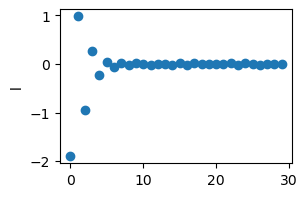

In [ ]:
sample1.plot_G('iw')
sample1.plot_G('w')
sample1.plot_G('tau')
sample1.plot_G('legendre')

# Sample

In [ ]:
import Sample

In [ ]:
s = Sample.sample(beta=20.0)

ValueError: Argument Z must be 2-dimensional.

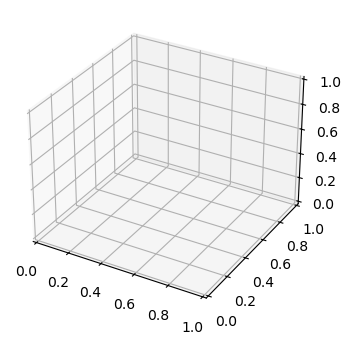

In [ ]:
s.plotBS()
s.plot_DOS(0.3)
s.plot_G0('iw')
s.plot_G0('w')
s.plot_G0('tau')
s.plot_G0('legendre')

In [ ]:
s.solve_impurity()


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
18:42:27   3% ETA 00:00:03 cycle 300 of 10000
18:42:29  67% ETA 00:00:01 cycle 6797 of 10000
18:42:30 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
18:42:30   5% ETA 00:00:01 cycle 286 of 5000
18:42:32 100% ETA 00:00:00 cycle 4999 of 5000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00763656
Average order         | 0.00608963
Average sign          | 0.00606303
G_l measure           | 0.0882523 
G_tau measure         | 0.0170963 
Total measure time    | 0.125138  
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.0641334
  Move  Insert

# Sample ml

In [ ]:
%load_ext autoreload
%autoreload 2

import Sample_ml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


model loaded from ./AUTOmodel_v3


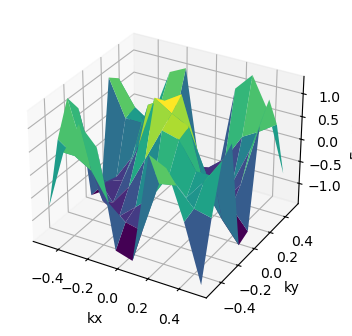

2024-08-10 19:45:40.913382
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 2.7242936240786693e-10
scaling alpha by a factor 2200 (number of data points)
alpha[ 0] =   4.40000000e+04, chi2 =   2.95556605e+03, n_iter=      33 
alpha[ 1] =   2.31446756e+04, chi2 =   1.33522735e+03, n_iter=      15 
alpha[ 2] =   1.21744547e+04, chi2 =   6.02248903e+02, n_iter=      16 
alpha[ 3] =   6.40395012e+03, chi2 =   2.70553630e+02, n_iter=      22 
alpha[ 4] =   3.36857609e+03, chi2 =   1.23918474e+02, n_iter=      23 
alpha[ 5] =   1.77192274e+03, chi2 =   5.86850274e+01, n_iter=      26 
alpha[ 6] =   9.32058570e+02, chi2 =   2.84354707e+01, n_ite

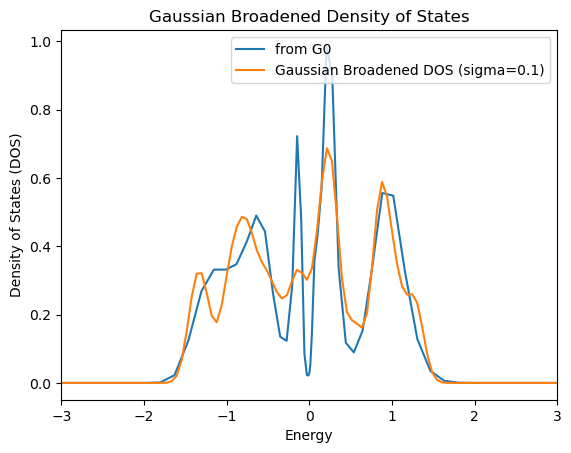

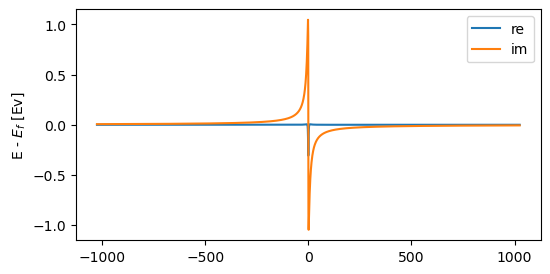

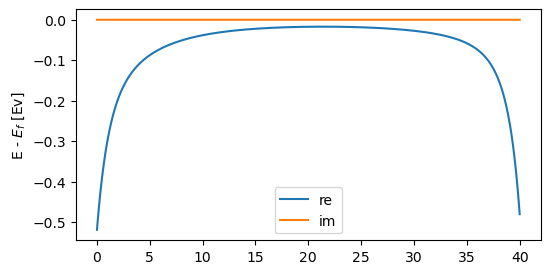

In [ ]:
s = Sample_ml.sample(beta=40.0)

s.plotBS()
s.plot_DOS(0.1)
s.plot_G0('iw')
# s.plot_G0('w')
s.plot_G0('tau')
# s.plot_G0('legendre')

In [ ]:
s.solve_impurity()


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-0.0275571*c_dag('down',0)*c('down',0) + -0.0275571*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
19:46:42   2% ETA 00:00:04 cycle 199 of 10000
19:46:44  49% ETA 00:00:02 cycle 4984 of 10000
19:46:46 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
19:46:46   3% ETA 00:00:02 cycle 190 of 5000
19:46:48  87% ETA 00:00:00 cycle 4354 of 5000
19:46:49 100% ETA 00:00:00 cycle 4999 of 5000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00803121
Average order         | 0.00613516
Average sign          | 0.00606135
G_l measure           | 0.273789  
G_tau measure         | 0.0284145 
Total 

2024-08-10 19:46:50.385631
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 2.7242936240786693e-10
scaling alpha by a factor 2200 (number of data points)
alpha[ 0] =   4.40000000e+04, chi2 =   2.95556605e+03, n_iter=      33 
alpha[ 1] =   2.31446756e+04, chi2 =   1.33522735e+03, n_iter=      15 
alpha[ 2] =   1.21744547e+04, chi2 =   6.02248903e+02, n_iter=      16 
alpha[ 3] =   6.40395012e+03, chi2 =   2.70553630e+02, n_iter=      22 
alpha[ 4] =   3.36857609e+03, chi2 =   1.23918474e+02, n_iter=      23 
alpha[ 5] =   1.77192274e+03, chi2 =   5.86850274e+01, n_iter=      26 
alpha[ 6] =   9.32058570e+02, chi2 =   2.84354707e+01, n_ite

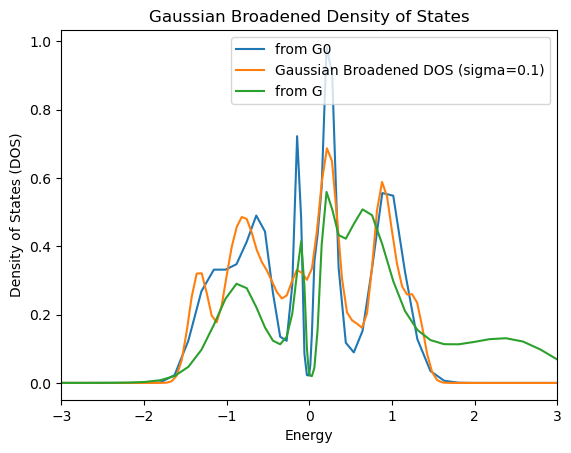

In [ ]:
s.plot_DOS(0.1)


# max ent

In [ ]:

err = 1.e-5
G_iw = GfImFreq(beta=10, indices=[0])
G_w = GfReFreq(window=(-10, 10), indices=[0])
G_iw << SemiCircular(1)-0.5*SemiCircular(0.5)
G_w << SemiCircular(1)-0.5*SemiCircular(0.5)
G_tau = GfImTime(beta=10, indices=[0], n_points=2501)
G_tau.set_from_fourier(G_iw)
G_tau.data[:, 0, 0] += err * np.random.randn(len(G_tau.data))



In [ ]:
from triqs_maxent import *

In [ ]:
tm = TauMaxEnt(cost_function='bryan', probability='normal')
tm.set_G_tau(G_tau)
tm.set_error(10*err)
result = tm.run()

2024-08-10 19:08:59.595992
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 35.595521693067475
scaling alpha by a factor 2501 (number of data points)
alpha[ 0] =   5.00200000e+04, chi2 =   1.21239251e+03, n_iter=      38 
alpha[ 1] =   2.63112880e+04, chi2 =   6.29270489e+02, n_iter=      15 
alpha[ 2] =   1.38401415e+04, chi2 =   3.05205265e+02, n_iter=      16 
alpha[ 3] =   7.28012693e+03, chi2 =   1.39193117e+02, n_iter=      17 
alpha[ 4] =   3.82945854e+03, chi2 =   6.57862956e+01, n_iter=      17 
alpha[ 5] =   2.01435399e+03, chi2 =   3.77913348e+01, n_iter=      15 
alpha[ 6] =   1.05958113e+03, chi2 =   2.83121938e+01, n_iter=  

In [ ]:
res = result

('Curvature: ', 7)
('LineFit: ', 6)
('Classic: ', 15)


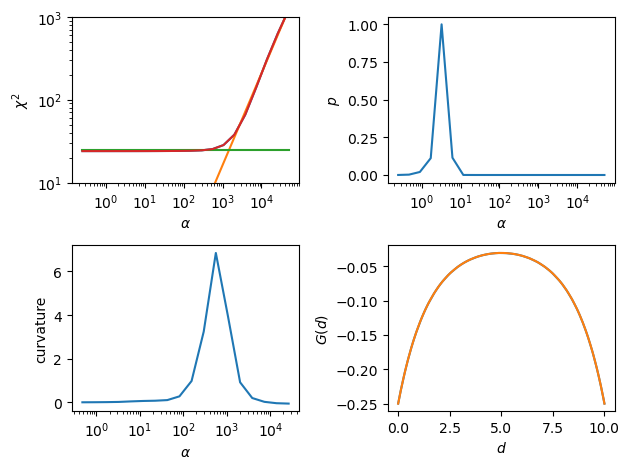

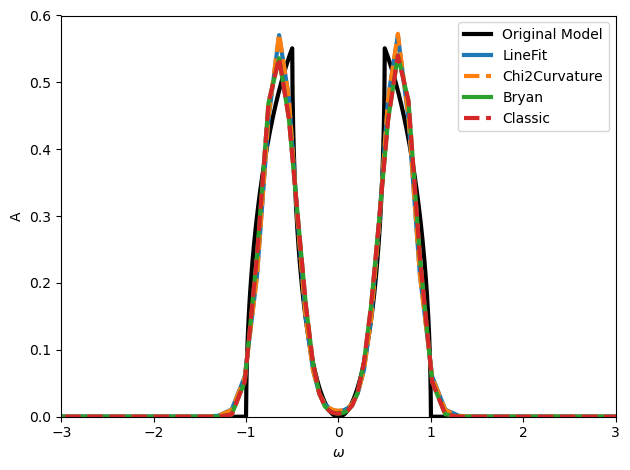

In [ ]:

fig1 = plt.figure()

# chi2(alpha) and linefit

plt.subplot(2, 2, 1)

res.analyzer_results['LineFitAnalyzer'].plot_linefit()

res.plot_chi2()

plt.ylim(1e1, 1e3)

# curvature(alpha)

plt.subplot(2, 2, 3)

res.analyzer_results['Chi2CurvatureAnalyzer'].plot_curvature()

# probablity(alpha)

plt.subplot(2, 2, 2)

res.plot_probability()

# backtransformed G_rec(tau) and original G(tau)

# by default (plot_G=True) also original G(tau) is plotted

plt.subplot(2, 2, 4)

res.plot_G_rec(alpha_index=5)

plt.tight_layout()


# spectral function A

fig2 = plt.figure()

oplot(G_w, mode='S', color='k', lw=3, label='Original Model')

plt.plot(res.omega, res.analyzer_results['LineFitAnalyzer']['A_out'],

         '-', lw=3, label='LineFit')

plt.plot(res.omega, res.analyzer_results['Chi2CurvatureAnalyzer']['A_out'],

         '--', lw=3, label='Chi2Curvature')

plt.plot(res.omega, res.analyzer_results['BryanAnalyzer']['A_out'],

         '-', lw=3, label='Bryan')

plt.plot(res.omega, res.analyzer_results['ClassicAnalyzer']['A_out'],

         '--', lw=3, label='Classic')


plt.legend()

plt.xlim(-3, 3)

plt.ylim(0, 0.6)

plt.ylabel('A')

plt.xlabel(r'$\omega$')

plt.tight_layout()


# print the optimal alpha-values

print(('Curvature: ',

      res.analyzer_results['Chi2CurvatureAnalyzer']['alpha_index']))

print(('LineFit: ', res.analyzer_results['LineFitAnalyzer']['alpha_index']))

print(('Classic: ', res.analyzer_results['ClassicAnalyzer']['alpha_index']))

In [ ]:
fig = plt.figure(constrained_layout=True)
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
axs['Left'].set_title('Plot on Left')
axs['TopRight'].set_title('Plot Top Right')
axs['BottomRight'].set_title('Plot Bottom Right')

NameError: name 'plt' is not defined